In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


## Logistic Regression for Males 50-70 yo.

### Get the data from the filesystem

In [13]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

### Get the feature importances (intersections)

In [14]:
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_50-70.csv", index_col=0)

### Filter dataset to get Males 50-70 yo. baseline samples for training, test and validation

In [15]:
mask = ((ppmi_ad.obs['Age_Group'] == '50-70') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [16]:
ppmi_ad = ppmi_ad[mask]

In [17]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]


### Display the amount of subjects for each cohort (_Visualize for class imbalance_)

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/3785693463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


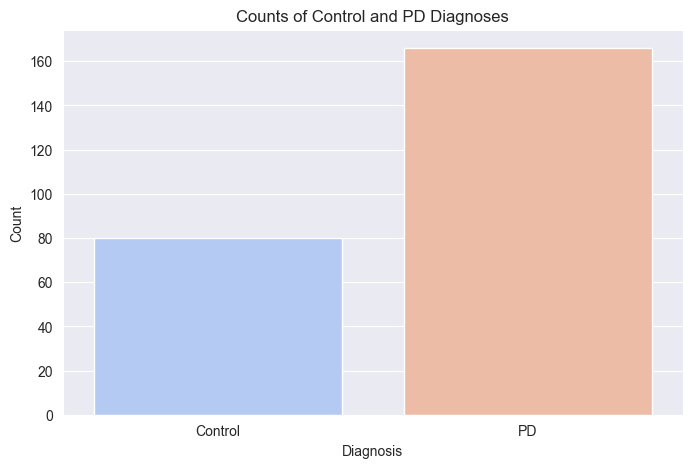

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

### Split Data and Outcode and create training and test sets
___
log2 transformed counts are used

In [20]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Setup Logistic Regression Pipeline

In [22]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

### Account for class imbalance by employing SMOTE
Smote will create synthetic samples for the minority class. SMOTE stands for synthetic minority Over-sampling technique.

In [23]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print(np.bincount(y_res))
print(np.bincount(y_train))

/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[132 132]
[ 64 132]


### Run Hyperparameter tuning and train

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [25]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [26]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.82      0.97      0.89        34

    accuracy                           0.84        50
   macro avg       0.86      0.77      0.79        50
weighted avg       0.85      0.84      0.83        50



In [27]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.875
PR-AUC: 0.923


### Print ROC, PR and Confusion Matrix

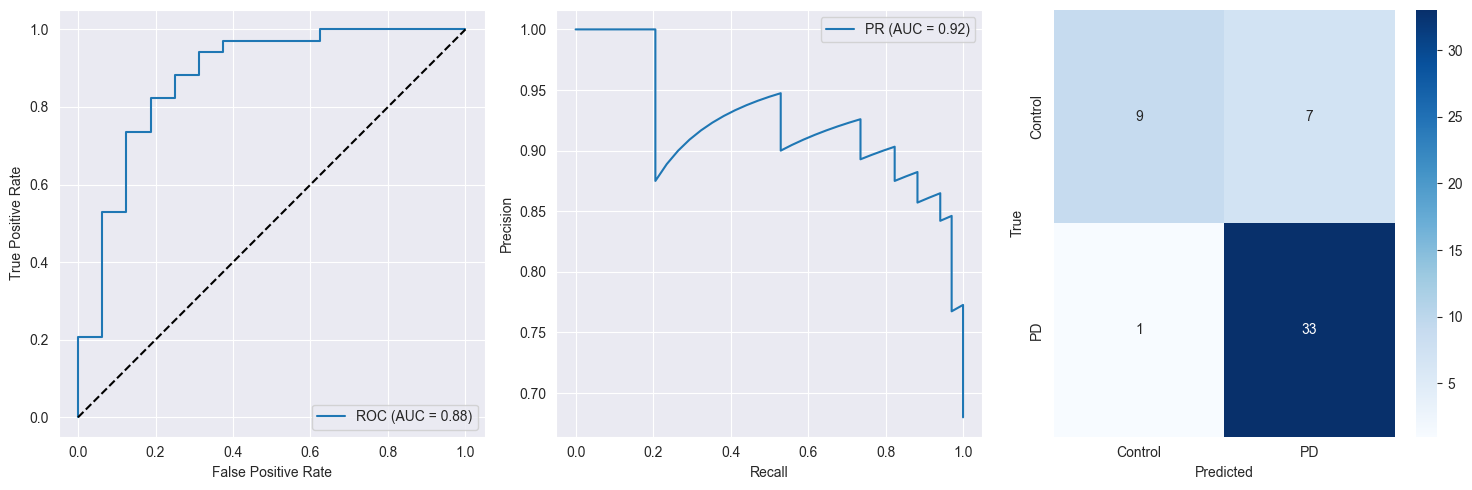

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Run 10-Fold Validation

In [29]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.895 ± 0.086
PR-AUC: 0.945 ± 0.050


In [30]:
coefficients = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'coefficient': lr_pipeline.named_steps['lr'].coef_[0],
    'abs_coef': np.abs(lr_pipeline.named_steps['lr'].coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 40 predictive genes:")
print(coefficients.head(40)[['gene_symbol', 'coefficient']])


Top 40 predictive genes:
                        gene_symbol  coefficient
ENSG00000238837.3         LINC02031     0.286592
ENSG00000202050.1         RNU6-391P    -0.263944
ENSG00000176318.8           FOXN3P1     0.250915
ENSG00000059573.8          ALDH18A1     0.247028
ENSG00000264734.1   ENSG00000264734    -0.244318
ENSG00000128016.5             ZFP36     0.242457
ENSG00000251470.1            ASNSP4     0.240970
ENSG00000274584.1   ENSG00000274584     0.226532
ENSG00000138668.18           HNRNPD    -0.219333
ENSG00000278004.1   ENSG00000278004     0.215997
ENSG00000145979.17           TBC1D7     0.215128
ENSG00000139405.15            RITA1     0.213829
ENSG00000276649.1   ENSG00000276649     0.212238
ENSG00000267120.3   ENSG00000267120    -0.212225
ENSG00000226065.1          ZBTB45P2    -0.208348
ENSG00000145725.19          PPIP5K2     0.204232
ENSG00000229571.7          PRAMEF25     0.204209
ENSG00000259674.1          RPL7AP75     0.202101
ENSG00000271096.1          SUMO2P14     0.2

### Extract Topmost Predictive Genes for LR Classification

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/888752835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


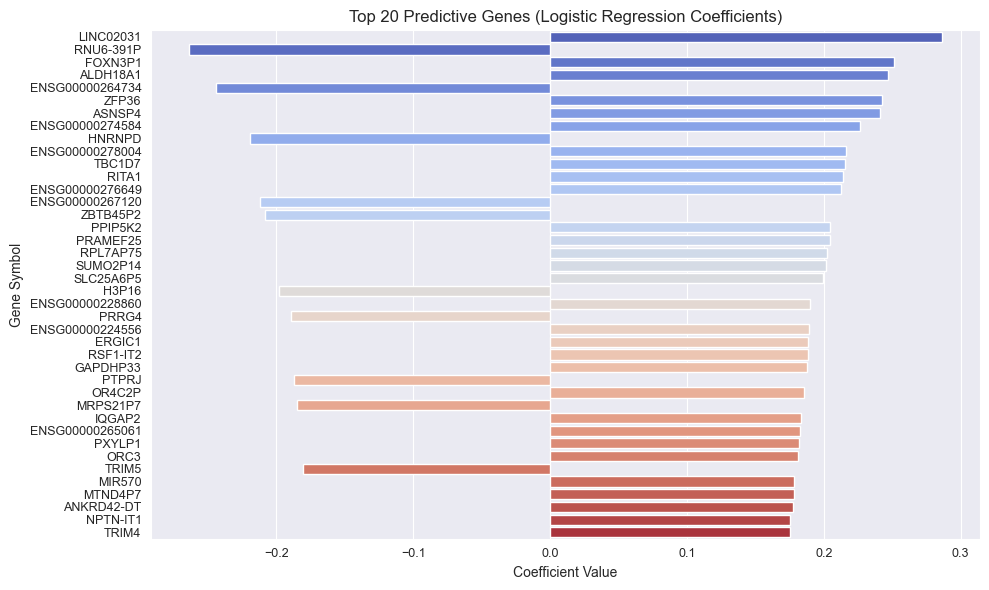

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients.head(40),
    x='coefficient',
    y='gene_symbol',
    palette='coolwarm'
)
plt.title('Top 20 Predictive Genes (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Conduct External Validation with samples from V02 (_2nd Visit_)

In [32]:
import anndata as ad
ppmi_ad_v02 = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [33]:
mask_v02 = ((ppmi_ad_v02.obs['Age_Group'] == '50-70') &
        (ppmi_ad_v02.obs['Gender'] == 'Male') &
        (ppmi_ad_v02.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad_v02.obs['Visit'] == 'V02'))

In [34]:
ppmi_ad_v02 = ppmi_ad_v02[mask_v02]


In [35]:
ppmi_ad_v02 = ppmi_ad_v02[:, ppmi_ad_v02.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/1570959102.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


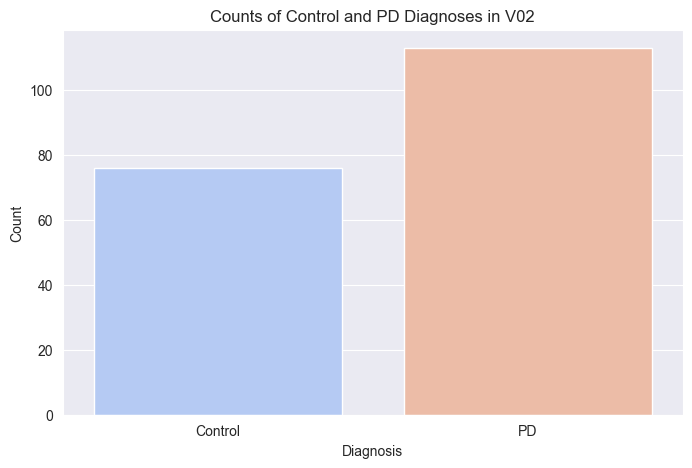

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad_v02.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses in V02')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [37]:
X = pd.DataFrame(ppmi_ad_v02.layers['counts_log2'], columns=ppmi_ad_v02.var_names)
y = (ppmi_ad_v02.obs['Diagnosis'] == 'PD').astype(int)


In [38]:
y_pred = best_lr.predict(X)
y_proba = best_lr.predict_proba(X)[:,1]

In [39]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.46      0.50        76
           1       0.67      0.75      0.71       113

    accuracy                           0.63       189
   macro avg       0.62      0.61      0.61       189
weighted avg       0.63      0.63      0.63       189



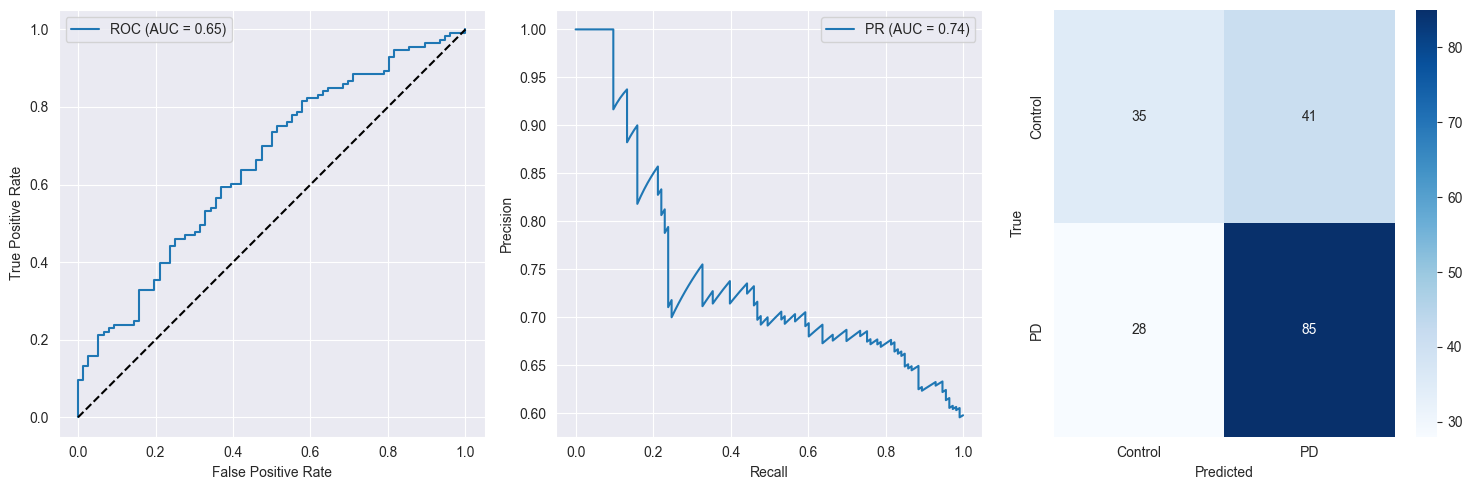

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Conduct External Validation with samples from V04


In [54]:
import anndata as ad
ppmi_ad_v04 = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [55]:
mask_v04 = ((ppmi_ad_v04.obs['Age_Group'] == '50-70') &
        (ppmi_ad_v04.obs['Gender'] == 'Male') &
        (ppmi_ad_v04.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad_v04.obs['Visit'] == 'V04'))

In [56]:
ppmi_ad_v04 = ppmi_ad_v04[mask_v04]


In [57]:
ppmi_ad_v04 = ppmi_ad_v04[:, ppmi_ad_v04.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/2277628096.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


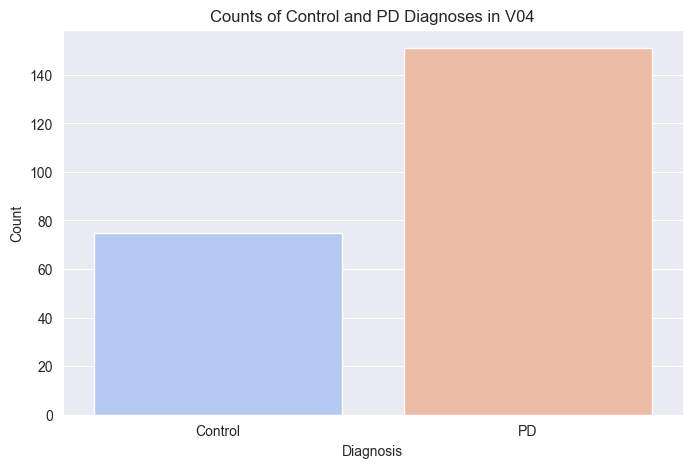

In [58]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad_v04.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses in V04')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [59]:
X = pd.DataFrame(ppmi_ad_v04.layers['counts_log2'], columns=ppmi_ad_v04.var_names)
y = (ppmi_ad_v04.obs['Diagnosis'] == 'PD').astype(int)


In [60]:
y_pred = best_lr.predict(X)
y_proba = best_lr.predict_proba(X)[:,1]

In [61]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.41      0.48        75
           1       0.74      0.84      0.79       151

    accuracy                           0.70       226
   macro avg       0.65      0.63      0.63       226
weighted avg       0.68      0.70      0.69       226



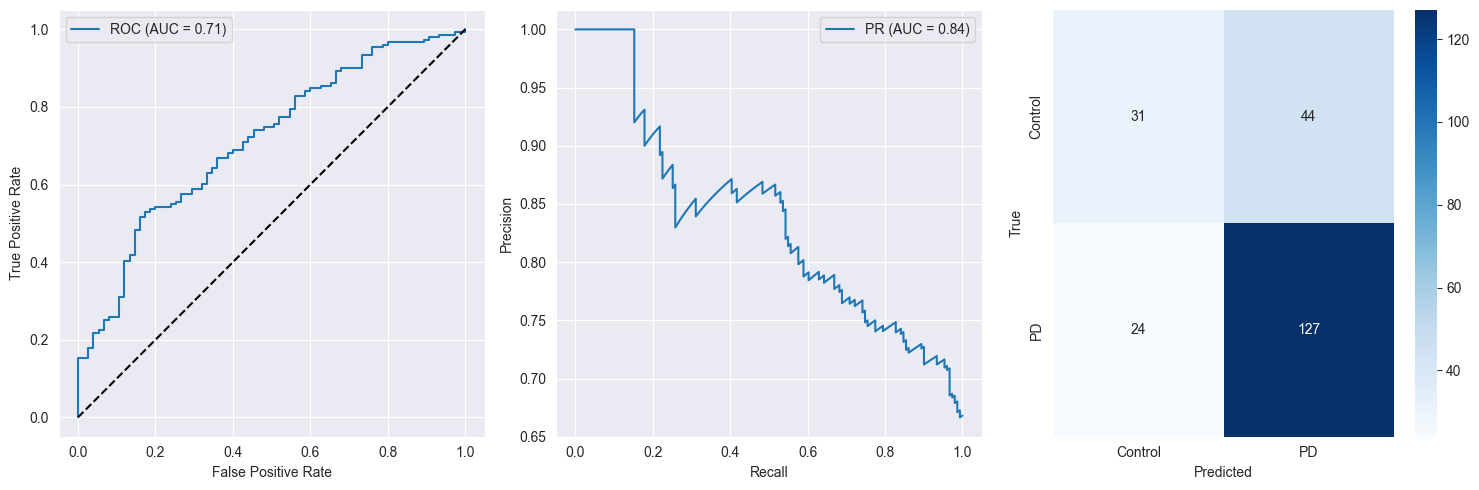

In [62]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Conduct External Validation with samples from V06

In [63]:
import anndata as ad
ppmi_ad_v06 = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [64]:
mask_v06 = ((ppmi_ad_v06.obs['Age_Group'] == '50-70') &
        (ppmi_ad_v06.obs['Gender'] == 'Male') &
        (ppmi_ad_v06.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad_v06.obs['Visit'] == 'V06'))

In [65]:
ppmi_ad_v06 = ppmi_ad_v06[mask_v06]


In [66]:
ppmi_ad_v06 = ppmi_ad_v06[:, ppmi_ad_v06.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/3139634563.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


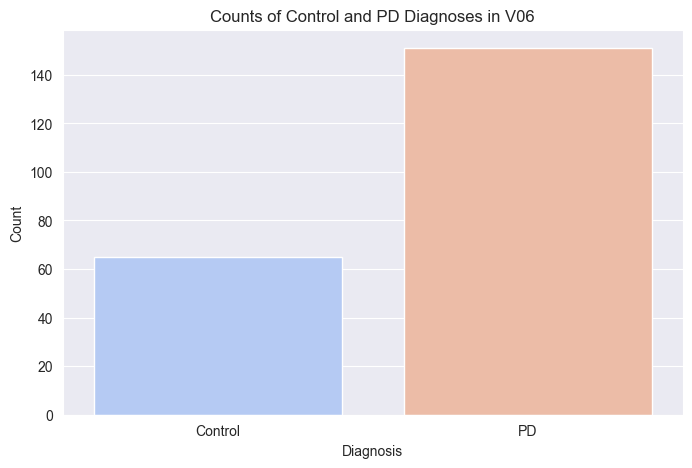

In [68]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad_v06.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses in V06')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [69]:
X = pd.DataFrame(ppmi_ad_v06.layers['counts_log2'], columns=ppmi_ad_v06.var_names)
y = (ppmi_ad_v06.obs['Diagnosis'] == 'PD').astype(int)


In [70]:
y_pred = best_lr.predict(X)
y_proba = best_lr.predict_proba(X)[:,1]

In [71]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        65
           1       0.75      0.86      0.80       151

    accuracy                           0.70       216
   macro avg       0.62      0.59      0.60       216
weighted avg       0.67      0.70      0.68       216



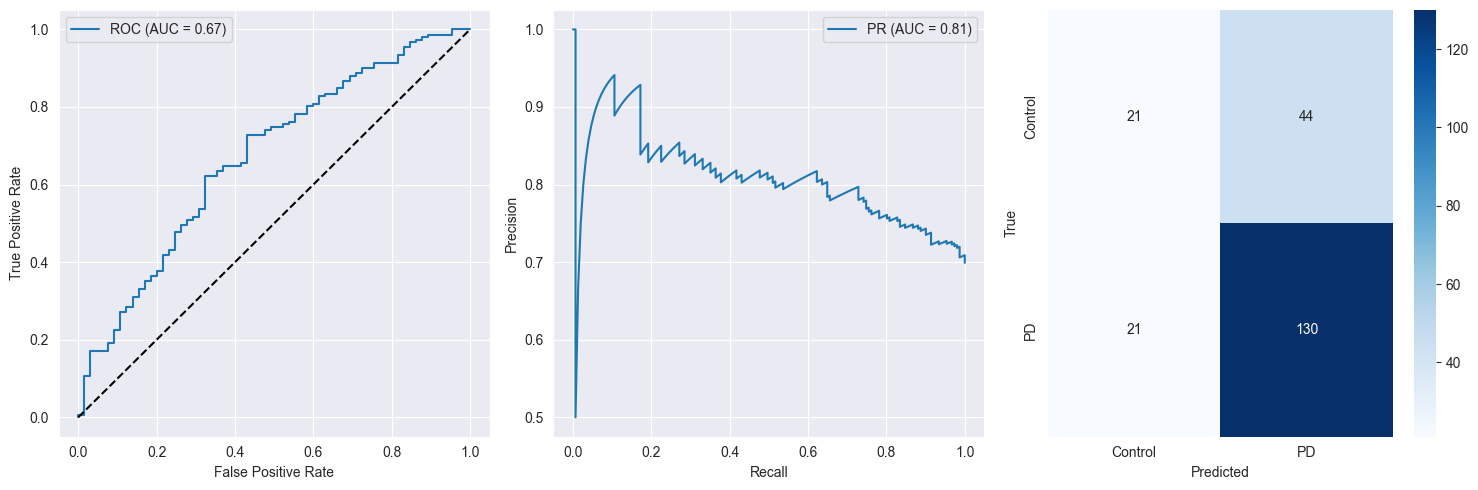

In [72]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Conduct External Validation with samples from V08


In [82]:
import anndata as ad
ppmi_ad_v08 = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [83]:
mask_v08 = ((ppmi_ad_v08.obs['Age_Group'] == '50-70') &
        (ppmi_ad_v08.obs['Gender'] == 'Male') &
        (ppmi_ad_v08.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad_v08.obs['Visit'] == 'V08'))

In [84]:
ppmi_ad_v08 = ppmi_ad_v08[mask_v08]


In [85]:
ppmi_ad_v08 = ppmi_ad_v08[:, ppmi_ad_v08.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_2107/3234172316.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


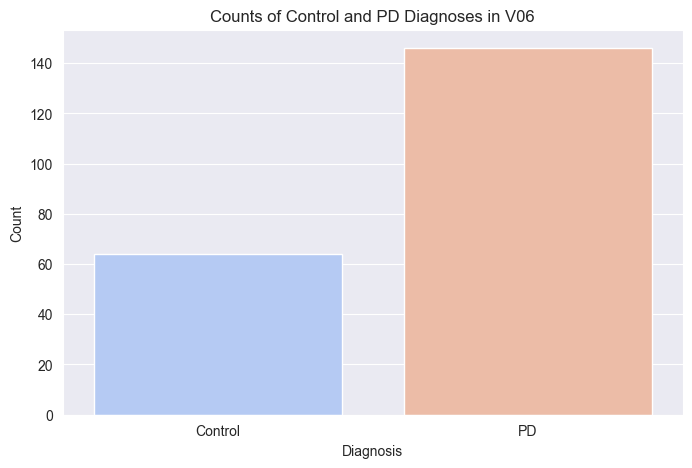

In [86]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad_v08.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses in V06')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [87]:
X = pd.DataFrame(ppmi_ad_v08.layers['counts_log2'], columns=ppmi_ad_v08.var_names)
y = (ppmi_ad_v08.obs['Diagnosis'] == 'PD').astype(int)


In [88]:
y_pred = best_lr.predict(X)
y_proba = best_lr.predict_proba(X)[:,1]

In [89]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.38      0.39        64
           1       0.74      0.76      0.75       146

    accuracy                           0.64       210
   macro avg       0.57      0.57      0.57       210
weighted avg       0.64      0.64      0.64       210



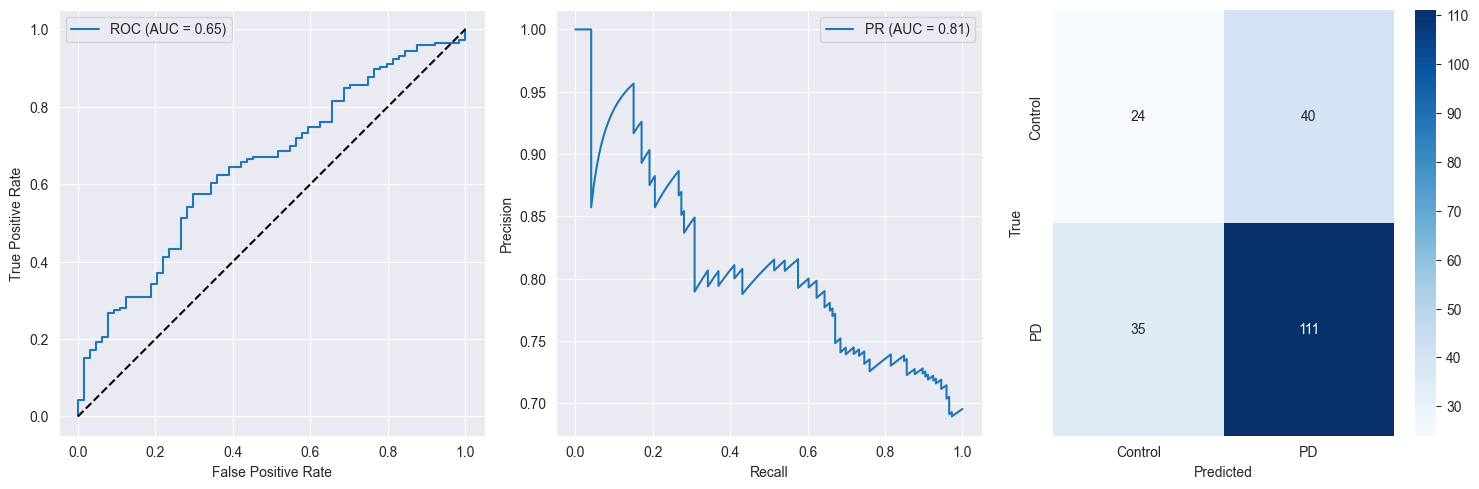

In [90]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Precision-Recall Tradeoff (best for imbalanced data)

In [118]:
optimal_idx = np.argmax(precision * recall)
optimal_threshold_pr = thresholds[optimal_idx]
print(f"Optimal PR Threshold: {optimal_threshold_pr:.3f}")

Optimal PR Threshold: 0.000


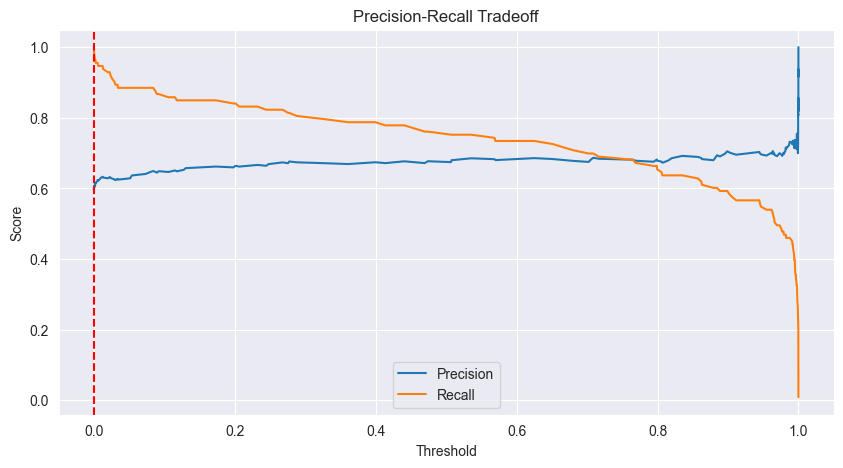

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [67]:
y_pred_custom = (y_proba[:len(y_test)] >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba[:len(y_test)]):.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [50, 24]

In [45]:
y_pred_custom

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [46]:
y_proba

array([9.99948294e-01, 2.69027376e-02, 9.99935072e-01, 2.15013449e-07,
       7.28956514e-05, 1.59122278e-02, 9.99961485e-01, 9.99939536e-01,
       5.06101700e-08, 9.99944119e-01])